In [1]:
import os
import torch
import numpy as np
import pandas as pd

import scanpy as sc
from anndata import AnnData
import anndata as ad

result_dir = "../edges/"
raw_type=False
use_edge=False
normalize=True

In [2]:
import matplotlib.pyplot as plt
# Set global font sizes using rcParams
plt.rcParams.update({
    'font.size': 18,            # Global font size
    'axes.titlesize': 20,       # Font size of the axes title
    'axes.labelsize': 20,       # Font size of the x and y labels
    'xtick.labelsize': 16,      # Font size of the x-tick labels
    'ytick.labelsize': 16,      # Font size of the y-tick labels
    'legend.fontsize': 18,      # Font size of the legend
    'figure.titlesize': 24      # Font size of the figure title
})

In [3]:
sample='Lung6'
data_dir = "../../data/NSCLC/processed1/"
str_position_x="CenterX_global_px"
str_position_y="CenterY_global_px"
str_cell_type="CellType"
cell_types=['B-cell', 'NK', 'T CD4 memory', 'T CD4 naive', 'T CD8 memory', 'T CD8 naive', 'Treg', 'endothelial', 'epithelial', 'fibroblast', 'mDC', 'macrophage', 'mast', 'monocyte', 'neutrophil', 'pDC', 'plasmablast', 'tumor 12', 'tumor 13', 'tumor 5', 'tumor 6', 'tumor 9']
print(cell_types)

genes = torch.load("/".join(data_dir.split("/")[:-2]) + "/genes.pth")
type_exp_dict=np.load(data_dir + sample + "_TypeExp.npz", allow_pickle=True)

cell_type_pair_sequence=[]
for cell_typei in cell_types:
    for cell_typej in cell_types:
        cell_type_pair_sequence.append(cell_typei+"->"+cell_typej)

feature_names=[]
for i in range(len(cell_types)):
    for j in range(len(genes)):
        feature_names.append(cell_types[i]+"--"+genes[j])

['B-cell', 'NK', 'T CD4 memory', 'T CD4 naive', 'T CD8 memory', 'T CD8 naive', 'Treg', 'endothelial', 'epithelial', 'fibroblast', 'mDC', 'macrophage', 'mast', 'monocyte', 'neutrophil', 'pDC', 'plasmablast', 'tumor 12', 'tumor 13', 'tumor 5', 'tumor 6', 'tumor 9']


In [4]:
print("HLA-DQA1" in genes)

True


In [5]:
def aggregate_interation_strength(sample,select_hvg=False):
    results=torch.load(result_dir+"edges_"+sample+".pth",map_location=torch.device('cpu'))

    position_x=results["position_x"][:,0]
    position_y=results["position_y"][:,0]
    cell_type_name=np.array(results["cell_type_name"])
    cell_type_target=cell_type_name[:,0]

    type_exps=torch.stack([torch.Tensor(type_exp_dict[cell_type_targeti]) for cell_type_targeti in cell_type_target],dim=0)
    results["y"]=results["y"]+type_exps
    
    attention_scores=results["attention_score"]
    cell_type_names = np.array(results["cell_type_name"])

    proportion=torch.abs(attention_scores)
    proportion=proportion/torch.sum(proportion,dim=1,keepdim=True)
    attention_scores[proportion<0.1]=0
    
    # Initialize a tensor to hold aggregated interaction strengths
    B, _, C = attention_scores.shape
    t = len(cell_types)
    aggregated_interactions = torch.zeros((B, t, C))
    
    # Map cell type names to indices
    cell_type_to_index = {ct: idx for idx, ct in enumerate(cell_types)}
    
    # Aggregate interaction strengths by cell type
    for b in range(B):
        for n in range(1, 50):  # Skip the first element, which is the target cell type
            neighbor_type = cell_type_names[b][n]
            if neighbor_type in cell_type_to_index:
                idx = cell_type_to_index[neighbor_type]
                aggregated_interactions[b, idx] += attention_scores[b, n-1]
    
    if normalize:
        aggregated_interactions1=aggregated_interactions/torch.sum(torch.abs(aggregated_interactions),dim=1,keepdim=True)
        aggregated_interactions=torch.where(torch.sum(torch.abs(aggregated_interactions),dim=1,keepdim=True)==0,torch.zeros_like(aggregated_interactions),aggregated_interactions1)
    
    #aggregated_interactions[torch.abs(aggregated_interactions)<0.025]=0

    adata = AnnData(aggregated_interactions.reshape(B,-1).numpy())
    adata.obs['cell_type'] = cell_type_target
    adata.obs['Spatial x']=position_x
    adata.obs['Spatial y']=position_y
    adata.var_names=feature_names
    adata.obsm["y"]=results["y"].numpy()

    # Quality control
    #sc.pp.filter_cells(adata, min_genes=200)
    #sc.pp.filter_genes(adata, min_cells=3)
    if select_hvg:
        # Quality control
        sc.pp.filter_cells(adata, min_genes=200)
        sc.pp.filter_genes(adata, min_cells=3)
        # Identify highly variable genes
        sc.pp.highly_variable_genes(adata, min_mean=0, max_mean=1, min_disp=0,n_top_genes=2000)
        adata = adata[:, adata.var.highly_variable]
    print(adata.shape)
    return adata

#adata=aggregate_interation_strength(sample)
#print(adata)

In [6]:
adata=sc.read_h5ad("../cluster/aggregated/"+sample+".h5ad")
#print(adata1.X.shape,adata.X.shape)
adata.obs["Spatial x"]=adata.obs["position_x"]
adata.obs["Spatial y"]=adata.obs["position_y"]

In [7]:
adata.X=np.abs(adata.X)

In [8]:
print(np.min(adata.X))

0.0


In [9]:
def select_hvg(adata):
    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0, max_mean=1, min_disp=0,n_top_genes=2000)
    adata = adata[:, adata.var.highly_variable]
    return adata

In [10]:
import matplotlib.pyplot as plt

def plot_cell_type(adata, fig_width=8, fig_height=6):
    with plt.rc_context({'figure.figsize': (fig_width, fig_height)}):
        sc.tl.pca(adata, n_comps=50)
        sc.pp.neighbors(adata)  # Compute the neighborhood graph
        sc.tl.umap(adata)  # Compute UMAP
        sc.pl.umap(adata, color='cell_type')

#plot_cell_type(adata, fig_width=6, fig_height=5)

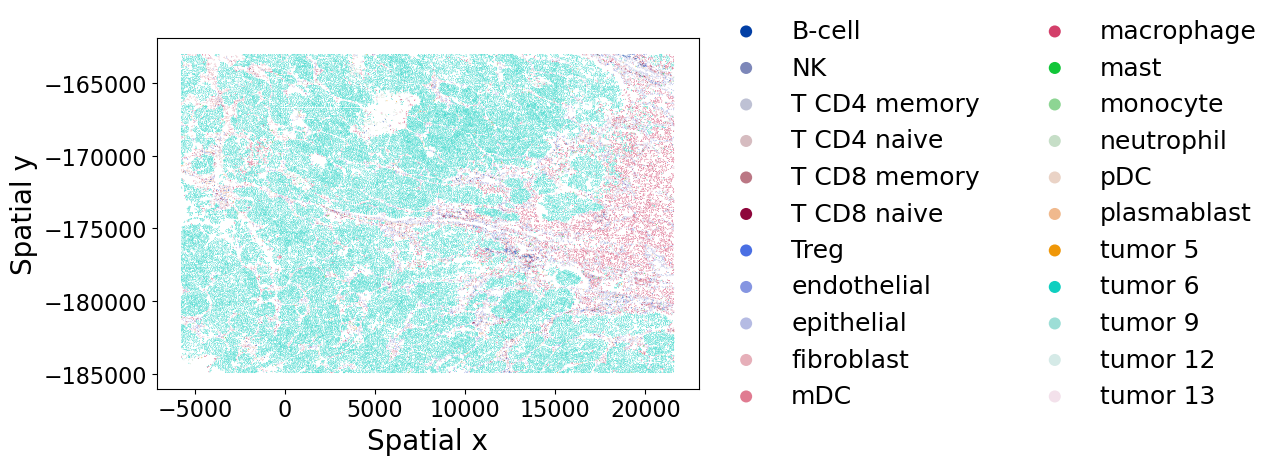

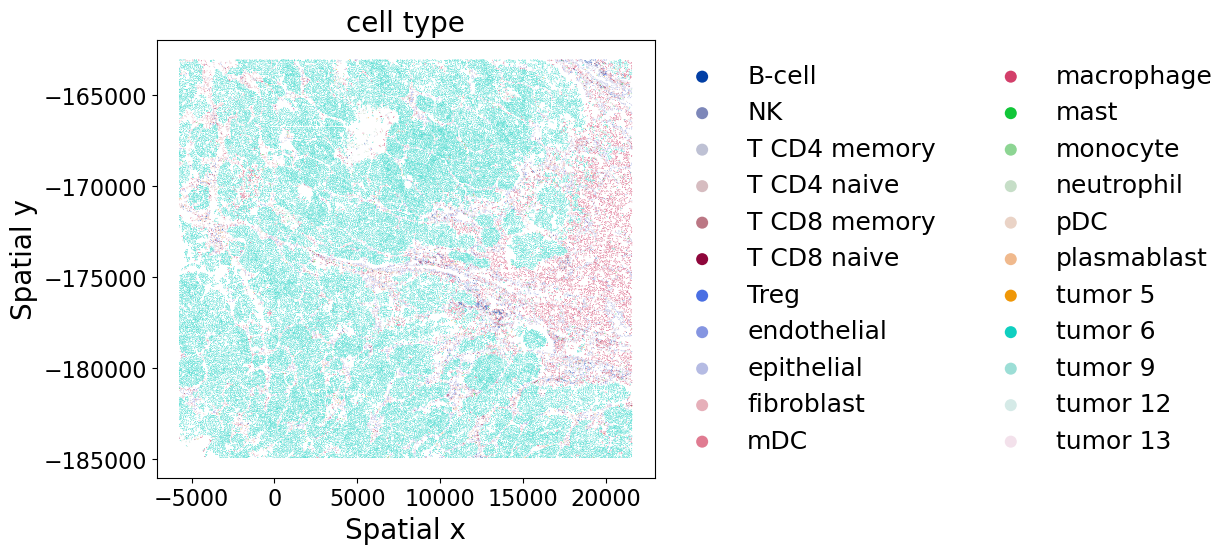

In [11]:
sc.pl.scatter(
        adata,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="cell_type",title="",save="SP.pdf"
    )
with plt.rc_context({'figure.figsize': (6,6)}):
    sc.pl.scatter(
        adata,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="cell_type"
    )

In [12]:
#plot_cell_type(ad.AnnData(X=np.abs(adata.obsm["y"]), obs=adata.obs), fig_width=6, fig_height=5)

In [13]:
print(cell_types)

['B-cell', 'NK', 'T CD4 memory', 'T CD4 naive', 'T CD8 memory', 'T CD8 naive', 'Treg', 'endothelial', 'epithelial', 'fibroblast', 'mDC', 'macrophage', 'mast', 'monocyte', 'neutrophil', 'pDC', 'plasmablast', 'tumor 12', 'tumor 13', 'tumor 5', 'tumor 6', 'tumor 9']


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


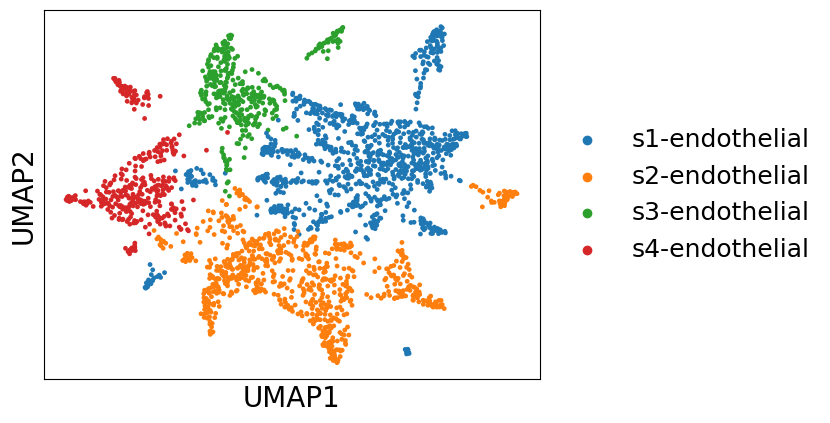

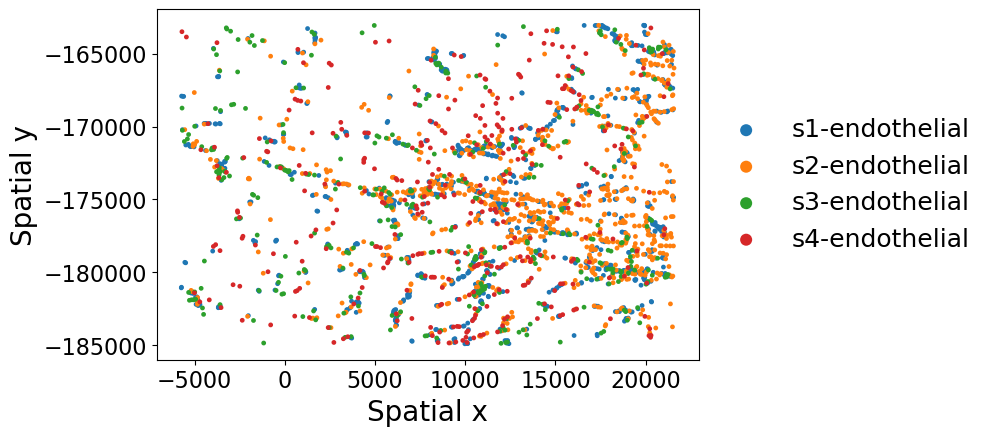

In [20]:
def plot(adata1,type_to_plot="Astrocyte",select=4,resolution=0.1):
    adata=adata1[adata1.obs["cell_type"]==type_to_plot]
    sc.tl.pca(adata, n_comps=50)
    sc.pp.neighbors(adata)  # Compute the neighborhood graph
    
    # Clustering
    sc.tl.leiden(adata,resolution=resolution)  # or sc.tl.louvain(adata)
    adata.obs["leiden"]=["s"+str(int(i)+1)+"-"+COI for i in adata.obs["leiden"].values]
    
    # Plot UMAP
    sc.tl.umap(adata)  # Compute UMAP
    sc.pl.umap(adata, color='leiden',title="",save=COI.replace("/","-")+"-umap.pdf")

    sc.pl.scatter(
        adata,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="leiden",
        title="",
        save=COI.replace("/","-")+"-sp.pdf"
    )
    '''
    adata_y=ad.AnnData(X=np.abs(adata.obsm["y"]), obs=adata.obs)
    adata_y.var_names=genes
    sc.tl.rank_genes_groups(adata_y, 'leiden', method='wilcoxon')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')
    sc.pl.rank_genes_groups_heatmap(adata_y, n_genes=select, show_gene_labels=True,standard_scale='var', cmap='viridis')

    adata_y_type=ad.AnnData(X=np.abs(adata.obsm["y"]), obs=adata.obs)
    adata_y_type.var_names=genes
    sc.tl.pca(adata_y_type, n_comps=50)
    sc.pp.neighbors(adata_y_type)  # Compute the neighborhood graph
    sc.tl.leiden(adata_y_type,resolution=0.5)  # or sc.tl.louvain(adata)
    sc.tl.umap(adata_y_type)  # Compute UMAP
    sc.pl.umap(adata_y_type, color='leiden')
    sc.pl.scatter(
        adata_y_type,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="leiden",
        title=f"Spatial cluster of {type_to_plot}"
    )
    sc.tl.rank_genes_groups(adata_y_type, 'leiden', method='wilcoxon')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')
    sc.pl.rank_genes_groups_heatmap(adata_y_type, n_genes=select, show_gene_labels=True, cmap='viridis')
    
    adata.obs['leiden_y']=adata_y_type.obs['leiden']
    print(adata)
    '''
    return adata

COI='endothelial'#'endothelial'#'macrophage'
resolution=0.06#0.056
adata_type=plot(adata,type_to_plot=COI,resolution=resolution)

# 'macrophage', yes, 0.056
# 'endothelial', yes, 0.06 3-th group for tumor
# 'tumor 6', yes 0.06
# 'B-cell': can be used in supplementary, 0.06
# 'T CD4 naive' may be, 0.06

In [21]:
# For tumor 6
if COI=='tumor 6':
    leidens=[]
    for i in range(len(adata_type.obs['leiden'])):
        if adata_type.obs['leiden'][i]=="s2-tumor 6" or adata_type.obs['leiden'][i]=="s3-tumor 6":
            leidens.append("s2-tumor 6")
        else:
            leidens.append("s1-tumor 6")
    adata_type.obs['leiden1']=np.array(leidens)
    sc.pl.umap(adata_type, color='leiden1',title="")
    sc.pl.scatter(
        adata_type,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="leiden1",
        title=""
    )
    adata_type.obs['leiden']=adata_type.obs['leiden1']

'''
adata_type.obs["Spatial x"]=adata_type.obs["position_x"]
adata_type.obs["Spatial y"]=adata_type.obs["position_y"]
sc.pl.scatter(
        adata_type,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="leiden",
        title=""
)
'''

'\nadata_type.obs["Spatial x"]=adata_type.obs["position_x"]\nadata_type.obs["Spatial y"]=adata_type.obs["position_y"]\nsc.pl.scatter(\n        adata_type,\n        x=\'Spatial x\',#\'Spatial x\',\n        y=\'Spatial y\',#\'Spatial y\',\n        color="leiden",\n        title=""\n)\n'

         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


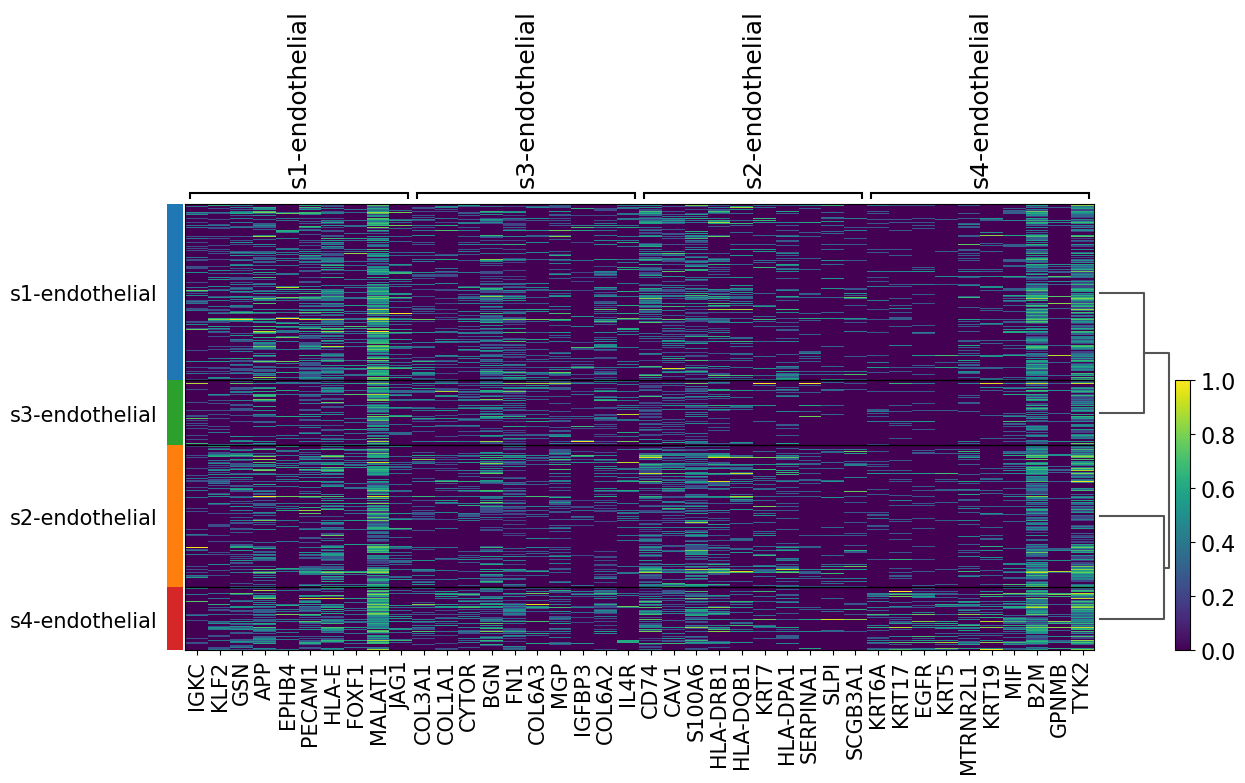

Group s1-endothelial:
Gene: IGKC, Adjusted p-value: 0.9997571133558321
Gene: KLF2, Adjusted p-value: 0.9997571133558321
Gene: GSN, Adjusted p-value: 0.9997571133558321
Gene: APP, Adjusted p-value: 0.9997571133558321
Gene: EPHB4, Adjusted p-value: 0.9997571133558321
Gene: PECAM1, Adjusted p-value: 0.9997571133558321
Gene: HLA-E, Adjusted p-value: 0.9997571133558321

Group s2-endothelial:
Gene: CD74, Adjusted p-value: 0.002265637535116304
Gene: CAV1, Adjusted p-value: 0.043536669802953294
Gene: S100A6, Adjusted p-value: 0.043536669802953294
Gene: HLA-DRB1, Adjusted p-value: 0.044120102806202585
Gene: HLA-DQB1, Adjusted p-value: 0.09628508789429135
Gene: KRT7, Adjusted p-value: 0.17192496887278758
Gene: HLA-DPA1, Adjusted p-value: 0.17192496887278758

Group s3-endothelial:
Gene: COL3A1, Adjusted p-value: 0.0586710991448435
Gene: COL1A1, Adjusted p-value: 0.11384386166026939
Gene: CYTOR, Adjusted p-value: 0.27213133992520566
Gene: BGN, Adjusted p-value: 0.534259872335118
Gene: FN1, Adjuste

In [22]:
select=10
adata_y=ad.AnnData(X=np.abs(adata_type.obsm["y"]), obs=adata_type.obs)
#adata_y=adata_y[adata_y.obs['leiden'].isin(["0","1"])]#,"2","2","3"
adata_y.var_names=genes
sc.tl.rank_genes_groups(adata_y, 'leiden', method='wilcoxon')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')
# Generate the heatmap without displaying it immediately
sc.pl.rank_genes_groups_heatmap(adata_y, 
                                n_genes=select, 
                                show_gene_labels=True, 
                                standard_scale='var', 
                                cmap='viridis', 
                                show=False)
# Access all axes in the current figure
axes = plt.gcf().get_axes()
# Loop through each axis and remove the y-axis label
for ax in axes:
    ax.set_ylabel('')
# Show the plot
plt.show()

def print_adjusted_pvals(adata, n_genes=7):
    # Perform differential expression analysis
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
    
    # Extract the results from rank_genes_groups
    results = adata.uns['rank_genes_groups']
    
    # Get the groups
    groups = results['names'].dtype.names
    
    # Iterate through each group and get the top n_genes
    for group in groups:
        print(f"Group {group}:")
        
        # Get the top n_genes and their corresponding adjusted p-values
        gene_names = results['names'][group][:n_genes]
        pvals_adj = results['pvals_adj'][group][:n_genes]
        
        # Print the results
        for gene, pval_adj in zip(gene_names, pvals_adj):
            print(f"Gene: {gene}, Adjusted p-value: {pval_adj}")
        print()

print_adjusted_pvals(adata_y)

In [35]:
def extract_genes_and_pvals_by_group(adata, group_index, cutoff=0.05, up=True, name=None):
    # Extracting gene names and p-values from the adata object
    gene_names = adata.uns['rank_genes_groups']['names']
    p_values = adata.uns['rank_genes_groups']['pvals']
    logfoldchanges=adata.uns['rank_genes_groups']['logfoldchanges']
    p_adj=adata.uns['rank_genes_groups']['pvals_adj']
    
    # Lists to hold filtered gene names and their corresponding p-values
    filtered_genes = []
    filtered_pvals = []
    
    # Iterate through each group in the gene names and p-values
    for gene_group, pval_group,fold_group in zip(gene_names, p_adj, logfoldchanges):
        gene = gene_group[group_index]
        pval = pval_group[group_index]
        foldchange=fold_group[group_index]
        
        # Check if p-value is below the cutoff and add to the lists if it is
        #print(pval,foldchange)
        if pval < cutoff and ((foldchange>0)==up):
            filtered_genes.append(gene)
            filtered_pvals.append(pval)
    
    return filtered_genes, filtered_pvals

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


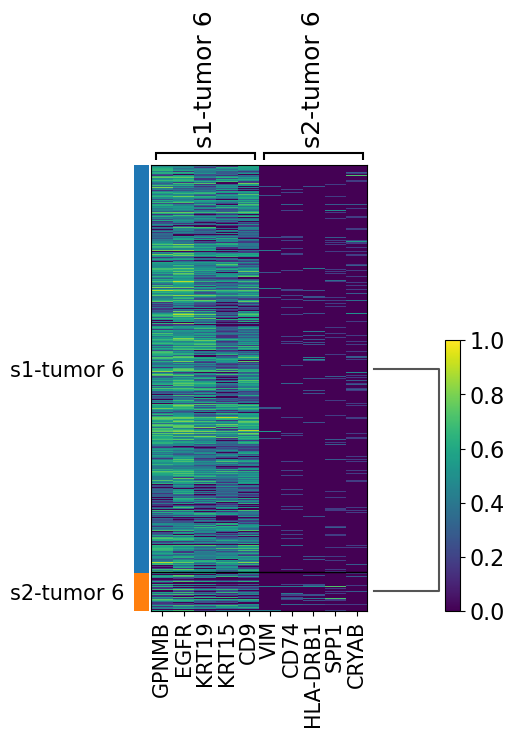

(['VIM', 'CD74', 'HLA-DRB1', 'SPP1', 'CRYAB', 'ANXA1', 'BGN', 'HLA-DRA', 'SERPINA1', 'HLA-DPA1', 'COL3A1', 'IGFBP7', 'FN1', 'CALD1', 'RGS1', 'COL1A2'], [3.7517909565461966e-27, 9.142699191760717e-21, 1.732245174749299e-10, 3.0631788840832893e-07, 6.037211097460164e-06, 1.79564275276586e-05, 3.5949452171105745e-05, 4.9254811118850816e-05, 5.458798737048608e-05, 5.9861404219143775e-05, 0.0004914875952197807, 0.0036011692688513717, 0.008884225232766637, 0.04010574505926377, 0.042869671316522646, 0.048540036110691895])
(['CDH5', 'BMX', 'CMKLR1', 'HBB', 'GPBAR1', 'CCL26', 'CCR1', 'OASL', 'COL17A1', 'UPK3A', 'TIGIT', 'SPINK1', 'IL18R1', 'SUCNR1', 'CD79A', 'VPREB3', 'NRIP3', 'CCL28', 'APOD', 'MXRA8', 'KRT86', 'SST', 'ESR1', 'C5AR2', 'GDF15', 'IAPP', 'CD55', 'IL16', 'TGFB3', 'CCL13', 'ITGA9', 'BEST1', 'FOXF1', 'CLEC1A', 'CD70', 'WNT11', 'CLEC14A', 'CD163', 'KRT23', 'CD19', 'CD5L', 'RARRES1', 'ADGRF3', 'TNFSF15', 'CCL19', 'FGF2', 'ADIPOQ', 'FPR1', 'DDR2', 'KLRK1', 'RAC2', 'C1QC', 'TWIST1', 'P2R

In [36]:
select=5
adata_y=ad.AnnData(X=np.abs(adata_type.obsm["y"]), obs=adata_type.obs)
#adata_y=adata_y[adata_y.obs['leiden'].isin(["0","1"])]#,"2","2","3"
adata_y.var_names=genes
sc.tl.rank_genes_groups(adata_y, 'leiden', method='wilcoxon')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')

# Generate the heatmap without displaying it immediately
sc.pl.rank_genes_groups_heatmap(adata_y, 
                                n_genes=select, 
                                show_gene_labels=True, 
                                standard_scale='var', 
                                cmap='viridis', 
                                show=False)
# Access all axes in the current figure
axes = plt.gcf().get_axes()
# Loop through each axis and remove the y-axis label
for ax in axes:
    ax.set_ylabel('')
# Show the plot
plt.savefig("./figures/"+COI.replace("/","-")+"-DE.pdf", bbox_inches='tight')
plt.show()

print(extract_genes_and_pvals_by_group(adata_y,1,0.05,True))
print(extract_genes_and_pvals_by_group(adata_y,1,0.05,False))

In [37]:
#sc.tl.rank_genes_groups(adata_type, 'leiden', method='wilcoxon')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')
#sc.pl.rank_genes_groups_heatmap(adata_type, n_genes=select, show_gene_labels=True,standard_scale='var', cmap='viridis')

#print(extract_genes_and_pvals_by_group(adata_type,1,0.05,True))
#print(extract_genes_and_pvals_by_group(adata_type,1,0.05,False))

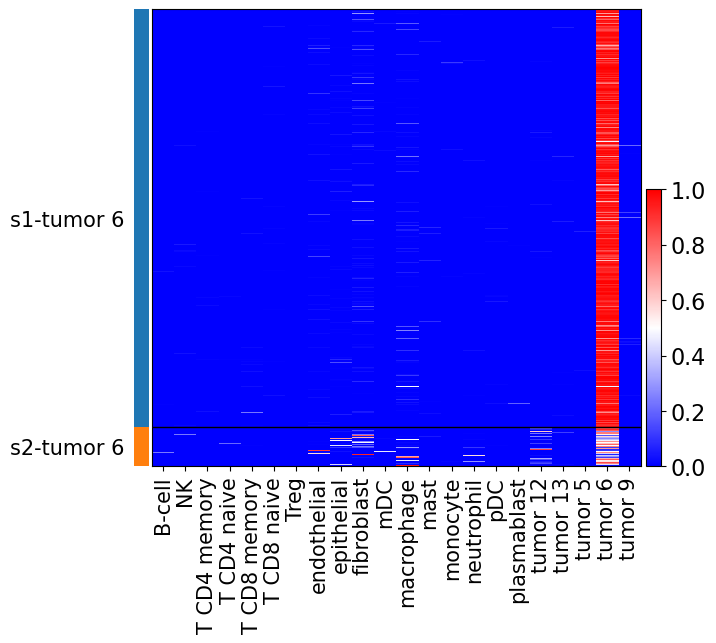

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


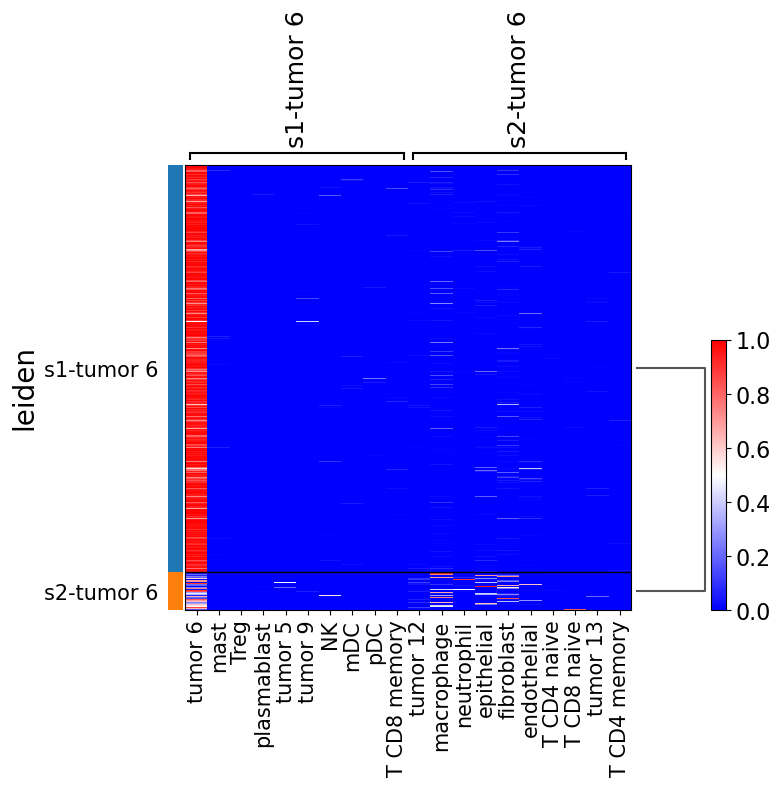

(['tumor 12', 'macrophage', 'neutrophil', 'epithelial', 'fibroblast', 'endothelial', 'T CD4 naive', 'T CD8 naive', 'tumor 13', 'T CD4 memory', 'monocyte', 'B-cell', 'T CD8 memory', 'pDC', 'mDC', 'NK'], [0.0, 0.0, 1.591395867023255e-208, 2.2355694679602997e-132, 6.2974558958819554e-130, 7.263813240608632e-50, 2.473413195445505e-27, 1.978230120174375e-11, 3.63791458203721e-09, 2.036147660274833e-06, 3.7827811393838803e-06, 1.0403010041483575e-05, 1.126268708128728e-05, 3.634288498370531e-05, 0.00029229265986683623, 0.0037963437224909718])
(['tumor 9', 'tumor 6'], [0.01031699790272959, 0.0])


In [38]:
def aggregate_all_genes(adata):
    x=np.zeros((adata.shape[0],len(cell_types)))
    for i in range(len(cell_types)):
        offset=i*len(genes)
        x[:,i]=np.mean(np.abs(adata.X[:,offset:offset+len(genes)]),axis=1)
    #c=adata.shape[1]//len(genes)
    #x=x/c
    adata1=ad.AnnData(X=x, obs=adata.obs)
    adata1.var_names=cell_types
    return adata1

adata_aggregated=aggregate_all_genes(adata_type)
sc.pl.heatmap(adata_aggregated, var_names=adata_aggregated.var_names, groupby='leiden', cmap='bwr',show=False)
# Get the current axis
ax = plt.gca()
# Remove the y-axis label
ax.set_ylabel('')
# Show the plot
plt.savefig("./figures/"+COI.replace("/","-")+"-heat.pdf", bbox_inches='tight')
plt.show()

sc.tl.rank_genes_groups(adata_aggregated, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_aggregated, n_genes=10, show_gene_labels=True, cmap='bwr')

print(extract_genes_and_pvals_by_group(adata_aggregated,1,0.05,True))
print(extract_genes_and_pvals_by_group(adata_aggregated,1,0.05,False))

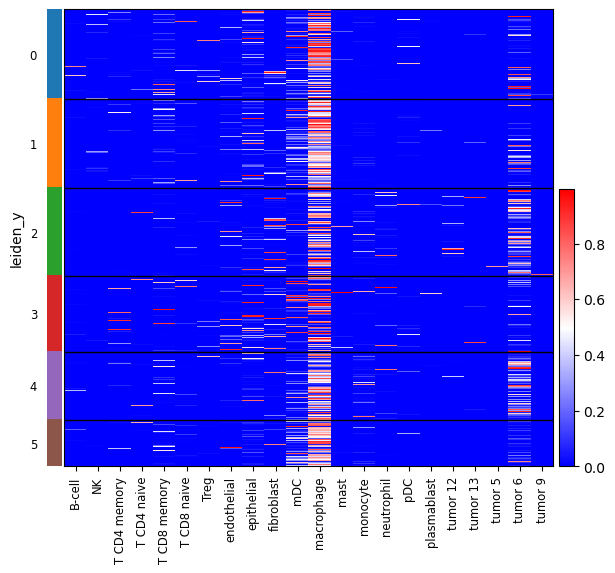

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


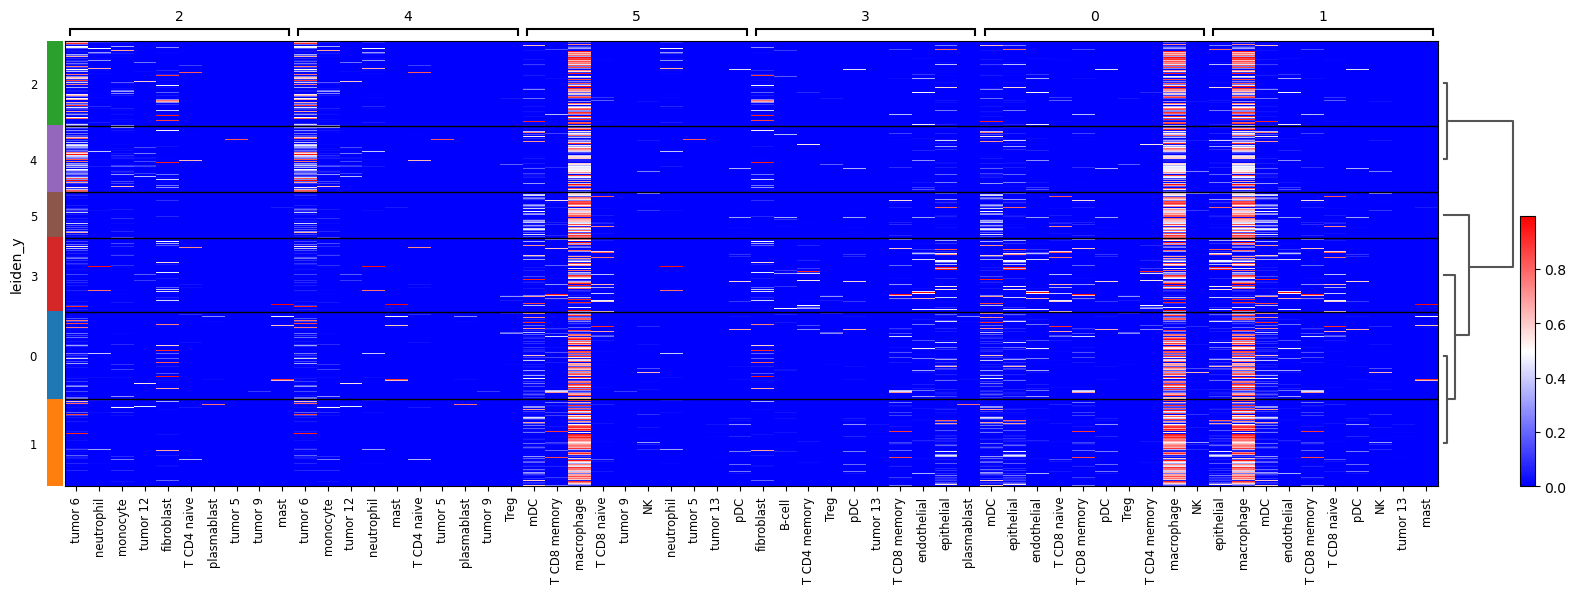

In [16]:
sc.pl.heatmap(adata_aggregated, var_names=adata_aggregated.var_names, groupby='leiden_y', cmap='bwr')
sc.tl.rank_genes_groups(adata_aggregated, 'leiden_y', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_aggregated, n_genes=10, show_gene_labels=True, cmap='bwr')

1.0
[0.457726   0.         0.         0.29953688 1.         0.
 0.         0.         1.         0.60716945 1.         1.
 0.         0.58288187 0.60851675 1.         0.         0.49851385
 0.         0.         1.         0.        ] [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -0.26487154 -1.         -0.57257414]


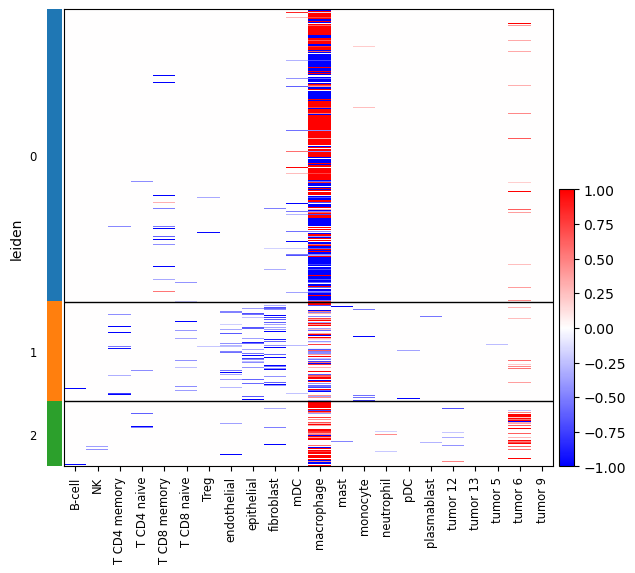

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered i

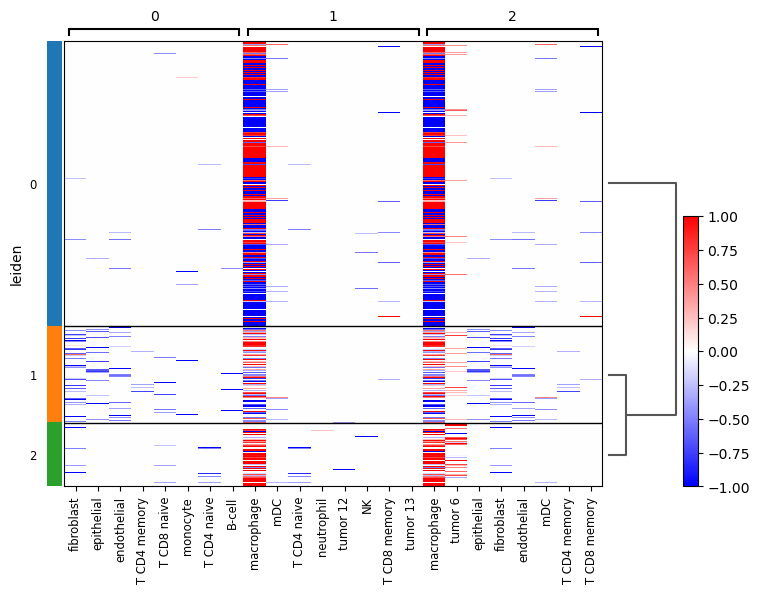

(['T CD8 naive', 'T CD4 memory', 'endothelial', 'epithelial', 'fibroblast'], [0.001733489299791034, 0.00015314688031140824, 9.991699253443075e-16, 3.820611518301662e-30, 2.65147375437533e-31])
([], [])


In [22]:
def select_CCI_genes(adata,gene):
    x=np.zeros((adata.shape[0],len(cell_types)))

    offset=genes.index(gene)
    for i in range(len(cell_types)):
        x[:,i]=x[:,i]+adata.X[:,i*len(genes)+offset]
    
    adata1=ad.AnnData(X=x, obs=adata.obs)
    adata1.var_names=cell_types
    return adata1
print(np.max(adata_type.X))
adata_gene=select_CCI_genes(adata_type,"SPP1")
#adata_gene=adata_gene[:,np.sum(adata_gene.X==0,axis=0)<=adata_gene.shape[0]*0.8]

print(np.max(adata_gene.X,axis=0),np.min(adata_gene.X,axis=0))

sc.pl.heatmap(adata_gene, var_names=adata_gene.var_names, groupby='leiden', cmap='bwr')

sc.tl.rank_genes_groups(adata_gene, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_gene, n_genes=8, show_gene_labels=True, cmap='bwr')

print(extract_genes_and_pvals_by_group(adata_gene,1,0.05,True))
print(extract_genes_and_pvals_by_group(adata_gene,1,0.05,False))

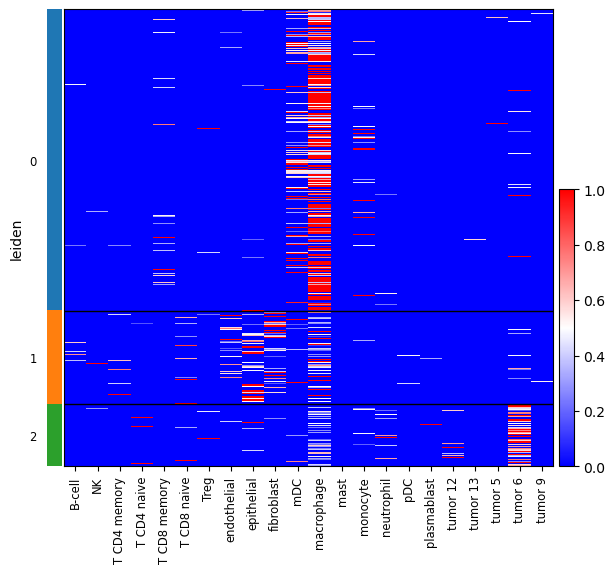

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


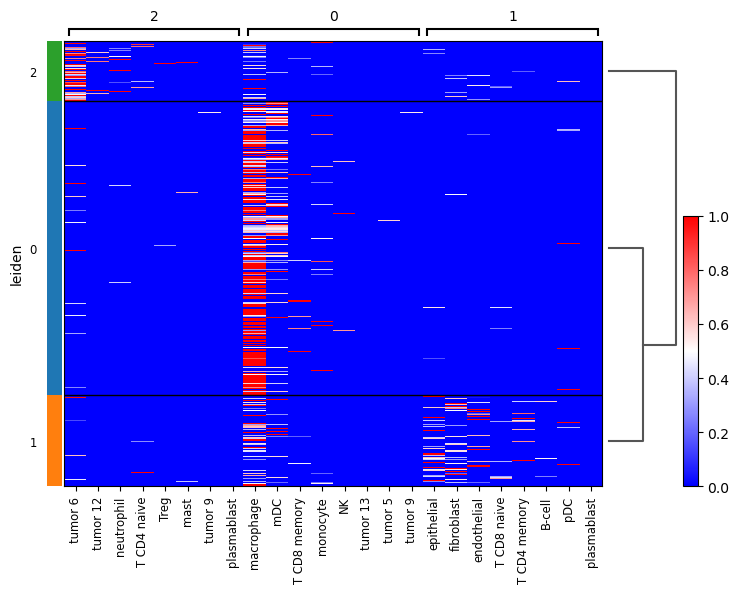

In [38]:
adata_gene=select_CCI_genes(adata_type,"HLA-DQA1")
sc.pl.heatmap(adata_gene, var_names=adata_gene.var_names, groupby='leiden', cmap='bwr')

sc.tl.rank_genes_groups(adata_gene, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_gene, n_genes=8, show_gene_labels=True, cmap='bwr')